# Black-Litterman Model

## Install External Libraries

In [0]:
!pip install PyPortfolioOpt
!pip install yfinance

## Import Dependencies

In [0]:
import matplotlib
import pypfopt
import datetime
import math

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Set Local Variables

In [0]:
risk_free_rate = 0.06501 # Risk-free rate of return, 10Yr Treasury Bond Yield
trading_days = 240 # No of trading days in a year

start_date = datetime.date(2000, 1, 1) # Oldest date to be considered for price analysis
investment_date = datetime.date(2019, 1, 1) # Date when funds are invested 
investment_end = datetime.date(2020, 5, 1) # Date of end of investment period

In [0]:
asset_universe = ['HDFC.BO', 'BAJFINANCE.BO', 'SBIN.BO', 'TITAN.BO', 'HDFCBANK.BO', 
                  'HEROMOTOCO.BO', 'INFY.BO', 'KOTAKBANK.BO', 'ONGC.BO', 'RELIANCE.BO',
                  'TATASTEEL.BO', 'LT.BO', 'M&M.BO', 'HINDUNILVR.BO', 'NESTLEIND.BO',
                  'ASIANPAINT.BO', 'ITC.BO', 'SUNPHARMA.BO', 'ICICIBANK.BO', 'INDUSINDBK.BO',
                  'AXISBANK.BO', 'HCLTECH.BO', 'BHARTIARTL.BO', 'MARUTI.BO','ULTRACEMCO.BO',
                  'TCS.BO', 'NTPC.BO', 'TECHM.BO', 'POWERGRID.BO','BAJAJ-AUTO.BO'
]

## Download Stock Prices

In [0]:
# Download historical closing prices
sensex30_history = yf.download(asset_universe, start=start_date, end=investment_end, auto_adjust=True).loc[:, 'Close']
sensex_history = yf.download('^BSESN', start=start_date, end=investment_end, auto_adjust=True).loc[:, 'Close']

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


In [0]:
# Rename Data Columns
rename_col_dict = dict()
for ticker in sensex30_history.columns:
  rename_col_dict[ticker] = ticker[:-3]

sensex30_history = sensex30_history.rename(columns=rename_col_dict)

## Compute and Plot Covariance Matrix

In [0]:
# Compute Covariance Matrix
sensex30_prices = sensex30_history.loc[start_date:investment_date , :].copy()
cov_matrix = pypfopt.risk_models.sample_cov(sensex30_prices, frequency=trading_days)

# Convert Covariance Matrix to Correlation Matrix
inv_diag = np.diag(1 / np.sqrt(np.diag(cov_matrix)))
corr_matrix = pd.DataFrame(np.dot(inv_diag, np.dot(cov_matrix, inv_diag)), index=cov_matrix.index, columns=cov_matrix.columns)


<Figure size 3000x2000 with 0 Axes>

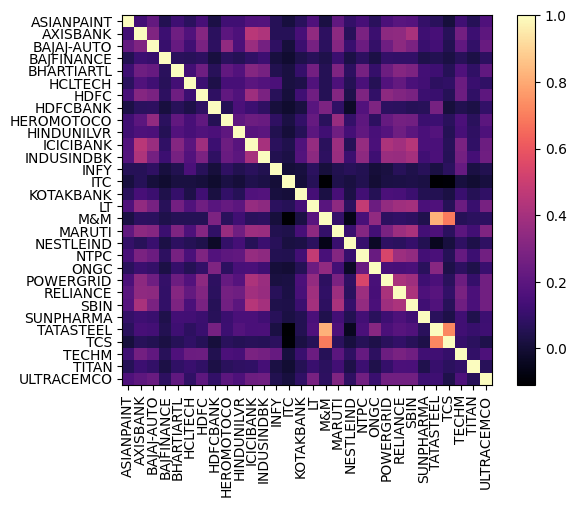

In [0]:
# Plot Covariance Matrix Heatmap
plt.style.use("default")
fig, ax = plt.subplots()

corr_ax = ax.imshow(corr_matrix, cmap="magma")

fig.colorbar(corr_ax)
ax.set_xticks(np.arange(0, corr_matrix.shape[0], 1))
ax.set_xticklabels(corr_matrix.index)
ax.set_yticks(np.arange(0, corr_matrix.shape[0], 1))
ax.set_yticklabels(corr_matrix.index)
plt.xticks(rotation=90)

plt.show()

## Compute market implied risk aversion factor (lambda)

In [0]:
sensex_prices = sensex_history.loc[start_date:investment_date].copy()
sensex_daily_returns = sensex_prices.squeeze().pct_change().dropna()
sensex_expected_returns = (1 + sensex_daily_returns.mean()) ** trading_days - 1
sensex_var = (1 + sensex_daily_returns.var()) ** trading_days - 1

risk_aversion = (sensex_expected_returns - risk_free_rate) / sensex_var

1.2561342702320946

## Compute Prior Returns

In [0]:
# Market capitalization for BSE Sensex 30 companies in cr.
market_caps = {
    "HDFC": 288066.09,
    "BAJFINANCE": 129212.73,
    "SBIN": 168318.17,
    "TITAN": 84535.00,
    "HDFCBANK": 509068.31,
    "HEROMOTOCO": 37725.77,
    "INFY": 273448.62,
    "KOTAKBANK": 220190.71,
    "ONGC": 82212.12,
    "RELIANCE": 864267.70,
    "TATASTEEL": 30251.88,
    "LT": 119702.85,
    "M&M": 42312.06,
    "HINDUNILVR": 560747.53,
    "NESTLEIND": 170066.24,
    "ASIANPAINT": 173868.99,
    "ITC": 224148.84,
    "SUNPHARMA": 113788.46,
    "ICICIBANK": 217587.37,
    "INDUSINDBK": 28824.12,
    "AXISBANK": 121677.52,
    "HCLTECH": 125534.15,
    "BHARTIARTL": 273459.81,
    "MARUTI": 156498.62,
    "ULTRACEMCO": 99249.51,
    "TCS": 664200.00,
    "NTPC": 96570.88,
    "TECHM": 51153.31,
    "POWERGRID": 84882.54,
    "BAJAJ-AUTO": 68937.35,
}

In [0]:
mcaps = pd.Series(market_caps)
rel_mkt_wts = mcaps / mcaps.sum()

bl_prior = risk_aversion * cov_matrix.dot(rel_mkt_wts) + risk_free_rate

In [0]:
# Plot Prior Returns

plt.style.use("seaborn-whitegrid")
bl_prior.plot(kind='barh')

## Compute and Plot View-based Posterior Estimate of Returns

In [0]:
"""
List of Views
1.   NBFCs will fall by 5% (BAJFINANCE) [50% Confidence]
2.   RELIANCE will rise by 10% (Absolute View) [70% Confidence]
3.   Auto sector will fall by 5% (HEROMOTOCO, M&M, MARUTI, BAJAJ-AUTO) [30% confidence]
4.   IT sector will rise by 10% (INFY, HCLTECH, TCS, TECHM)[60% confidence]
"""

view_dict = {
    "BAJFINANCE": -0.05,
    "RELIANCE": 0.1,
    "HEROMOTOCO": -0.05,
    "M&M": -0.05,
    "MARUTI": -0.05,
    "BAJAJ-AUTO": -0.05,
    "INFY": 0.1,
    "HCLTECH": 0.1,
    "TCS": 0.1,
    "TECHM": 0.1, 
}

view_confidences = [
    0.5,
    0.7,
    0.3,
    0.3,
    0.3,
    0.3,
    0.6, 
    0.6,
    0.6,
    0.6
]

In [0]:
# Compute posterior estimate of returns based on views
bl = pypfopt.black_litterman.BlackLittermanModel(cov_matrix, pi=bl_prior, absolute_views=view_dict, view_confidences=view_confidences, omega='idzorek')
bl_returns = bl.bl_returns()

In [0]:
# Plot Posterior Returns
# plt.style.use("seaborn-whitegrid")
# bl_returns.plot(kind="barh", title="Expected Returns")

## Optimal BL Portfolio: Max Sharpe

In [0]:
ef = pypfopt.efficient_frontier.EfficientFrontier(bl_returns, cov_matrix)
ef.max_sharpe(risk_free_rate)
max_sharpe_wts = ef.clean_weights()
ef.portfolio_performance(verbose=True)

max_sharpe_nonzero_wts = dict()
for key, val in max_sharpe_wts.items():
  if val != 0:
    max_sharpe_nonzero_wts[key] = val

Expected annual return: 14.1%
Annual volatility: 31.8%
Sharpe Ratio: 0.38


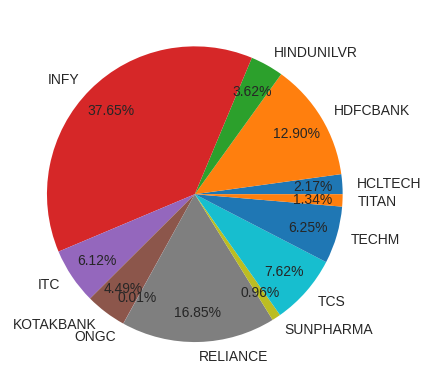

In [0]:
# Plot Maximum Sharpe Ratio Portfolio
plt.style.use("seaborn-whitegrid")
plt.pie(max_sharpe_nonzero_wts.values(), labels=max_sharpe_nonzero_wts.keys(), autopct="%.2f%%", pctdistance=0.8)
plt.show()

## Optimal BL Portfolio: Min Volatility

In [0]:
ef = pypfopt.efficient_frontier.EfficientFrontier(bl_returns, cov_matrix)
ef.min_volatility()
min_volatility_wts = ef.clean_weights()
ef.portfolio_performance(verbose=True)

min_volatility_nonzero_wts = dict()
for key, val in min_volatility_wts.items():
  if val != 0:
    min_volatility_nonzero_wts[key] = val

Expected annual return: 7.4%
Annual volatility: 14.6%
Sharpe Ratio: 0.37


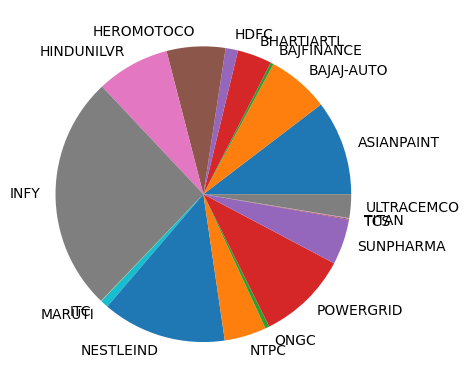

In [0]:
# Plot Minimum Volatility Ratio Portfolio
plt.style.use("default")
plt.pie(min_volatility_nonzero_wts.values(), labels=min_volatility_nonzero_wts.keys())
plt.show()

## Performace Analysis of Black-Litterman Model

In [0]:
# Slice price datasets to required time-ranges
sensex_prices = sensex_history.loc[investment_date:investment_end].copy()
sensex30_prices = sensex30_history.loc[investment_date:investment_end].copy()

In [0]:
# Create dataframe to analyse portfolio performance
portfolio_performance = pd.DataFrame(index=sensex_prices.index)

# Import Sensex benchmark price value data
portfolio_performance['Sensex'] = sensex_prices

In [0]:
# Import Max Sharpe portfolio price value
max_sharpe_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in max_sharpe_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  max_sharpe_val[index] = val

portfolio_performance['Max Sharpe'] = max_sharpe_val

In [0]:
# Import Min Volatility portfolio price value
min_volatility_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in min_volatility_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  min_volatility_val[index] = val

portfolio_performance['Min Volatility'] = min_volatility_val

In [0]:
# Compute and Plot Relative Portfolio Performance
portfolio_performance = portfolio_performance.pct_change()

# Normalise data to measure relative percentage change over time
for label, content in portfolio_performance.iteritems():
  for index, value in content.iteritems():
    if math.isnan(value):
      portfolio_performance.loc[index, label] = 100
      prev_index = index
    else:
      portfolio_performance.loc[index, label] = portfolio_performance.loc[prev_index, label] * (1 + value)
      prev_index = index

In [0]:
# Plot Relative Value Graph
plt.style.use('seaborn-whitegrid')
portfolio_performance.plot(grid=True)
plt.ylabel("Relative Value")
plt.show()

In [0]:
# Print LaTeX-friendly portfolio compositions
for ticker in sensex30_prices.columns.values:
  print(ticker + ' & ' + str(round(max_sharpe_wts[ticker]*100, 2)) + '\% & ' + str(round(min_volatility_wts[ticker]*100, 2)) + '\% \\\\' )

In [0]:
# Print LaTeX-friendly expected returns of assets
for ticker in sensex30_prices.columns.values:
  print(ticker + ' & ' + str(round(bl_prior[ticker]*100, 2)) + '\% & ' + str(round(bl_returns[ticker]*100, 2)) + '\% \\\\' )